In [17]:
from data import generate_dataframe

df = generate_dataframe()

Loading data from: ['AMAZON_FASHION_5.json', 'Home_and_Kitchen_5.json', 'Appliances_5.json', 'Digital_Music_5.json']

filename             samples
AMAZON_FASHION_5     3176   
Home_and_Kitchen_5   6898955
Appliances_5         2277   
Digital_Music_5      169781 

Data loaded, 7074189 total samples.


In [2]:
from preprocessing import preprocess_samples
from utils import get_product_reviews

raw_corpus_samples = list(filter(lambda x: isinstance(x, str), df['reviewText']))
corpus_samples = preprocess_samples(raw_corpus_samples)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/shy/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/shy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/shy/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Applying lowercase


175060it [00:00, 2051375.14it/s]


Applying remove_punctuation


175060it [00:00, 224712.51it/s]


Applying lemmatize


175060it [05:00, 581.69it/s] 


In [3]:
from train import get_tf_vectorizer

tf_vectorizer = get_tf_vectorizer()

Loading pretrained vectorizer...


In [5]:
product_id = 'B009MA34NY'
raw_product_samples = get_product_reviews(df, product_id)
product_samples = preprocess_samples(raw_product_samples)

product_documents = tf_vectorizer.transform(product_samples)

Applying lowercase


375it [00:00, 2656864.86it/s]


Applying remove_punctuation


375it [00:00, 278383.01it/s]


Applying lemmatize


375it [00:00, 813.26it/s]


Initializing LDA model...
Fitting LDA model...


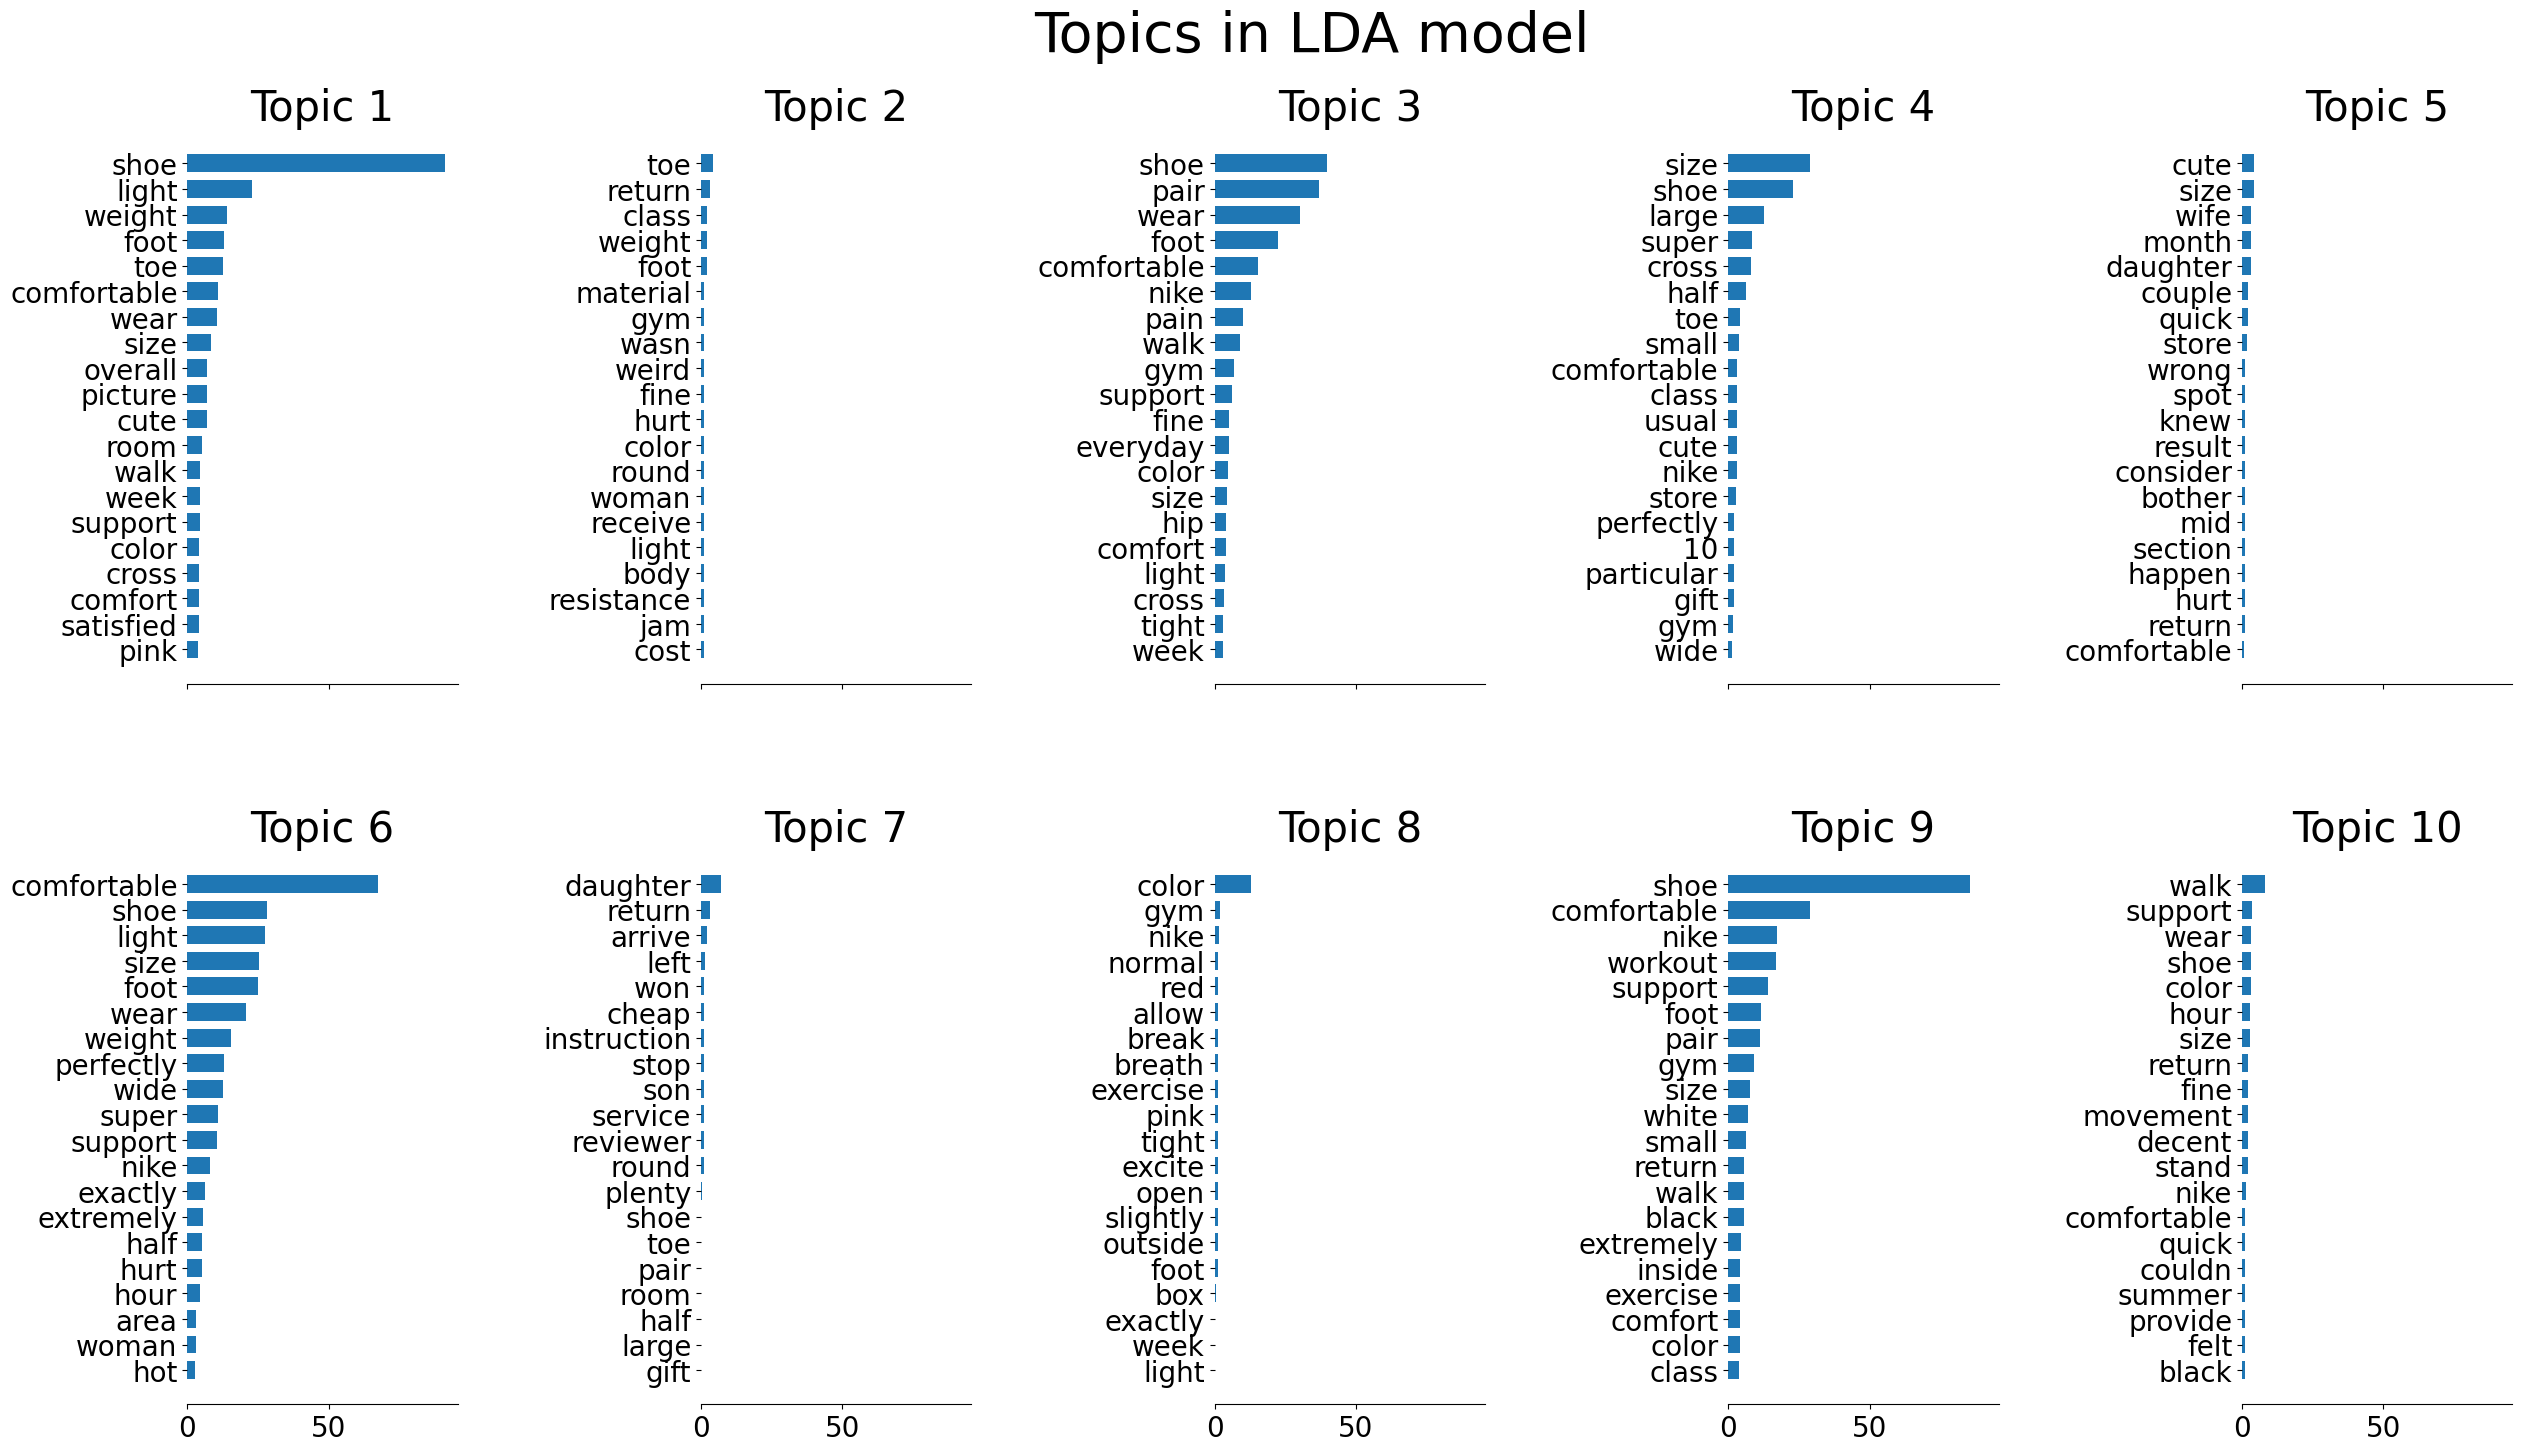

In [7]:
from utils import plot_top_words
from train import get_lda
lda = get_lda(samples=product_documents)

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, 20, "Topics in LDA model")

# Exploration

In [8]:
df['asin'].value_counts()[:20]

B0006GVNOA    2040
B00CZF8B68     574
B009MA34NY     377
B0092UF54A     376
B010RRWKT4     376
B005AGO4LU     376
B014IBJKNO     375
B0014F7B98     374
B0058YEJ5K     367
B001IKJOLW     365
B00BWGHIHY     316
B00136J7ZE     294
B00EH49FRE     283
B00136NUG6     262
B0170K9UTO     259
B002HP8EKE     253
B00122X5VG     244
B0092MKTWQ     233
B0011Z764Q     222
B00JLJ185C     219
Name: asin, dtype: int64

In [9]:
tf_vectorizer.stop_words_

{'venture',
 'flurry',
 'putain',
 '3998',
 'stellar',
 'kunde',
 'mi',
 'lear',
 'englishman',
 'swashbuckler',
 'jorma',
 'wurdalak',
 'potentially',
 'rawks',
 'hellboy',
 'm5',
 'morever',
 'invite',
 'hard',
 'concerts',
 'transact',
 'reallyconsidered',
 'comprarlo',
 'boyz',
 'syndrome',
 'meliora',
 'debbi',
 '24bit',
 'quibble',
 'changeover',
 's023',
 'omnipotent',
 'tapout',
 'fiat',
 '18th',
 'matchbox',
 'k068',
 'buh',
 'hurst',
 'cyris',
 'tenore',
 'sunfor',
 'soundproofing',
 'travail',
 'cellos',
 'srt',
 'fugue',
 'pouch',
 'hae',
 'mastero',
 'b005gycwry',
 'indication',
 'lofi',
 'fedoseyev',
 'slingshot',
 'onstgage',
 'cruising',
 'enjoys',
 'twv',
 'imbues',
 's059',
 'overpay',
 'lucey',
 'holister',
 'clubhouse',
 'sohn',
 'versions',
 'harbor',
 '2010s',
 'turismo',
 'comprise',
 'coing',
 'trick',
 'netherlands',
 'wholesomely',
 'hubbie',
 'pizzaz',
 'ellie',
 'stepford',
 'lova',
 'irrepressible',
 'paperbound',
 'tht',
 'skyscraping',
 'flynn',
 'steamro

In [10]:
from preprocessing import preprocess_sample

raw_reviews = list(filter(lambda x: isinstance(x, str), df[df['asin'] == product_id]['reviewText']))
processed_sentences, raw_sentences = preprocess_sample(raw_reviews[337], get_raw=True)

processed_sentences

Applying lowercase


3it [00:00, 79137.81it/s]


Applying remove_punctuation


3it [00:00, 69518.85it/s]


Applying lemmatize


3it [00:00, 477.49it/s]


['comfortable and lightweight',
 "need a good training shoe that's also supportive and flexible",
 'i really like the fit but have to get 1/2 size large a this style in my size be too perfect from heel to toe']

In [11]:
for i, sample in enumerate(raw_reviews):
    if len(sample) > 300 and len(sample) < 700:
        print(sample)#i,":", sample)

4 : Tried them on in a store before buying online so I knew they'd fit good. Overall I was looking for a durable cross training shoe that would hold up to my rigorous training and these have been great so far. They are really light and comfortable. Most importantly for me they have grips on the bottoms so my feet don't slide out from under me while doing planks, push-ups, etc. Highly satisfied with this purchase.
60 : Glad I read the reviews and ordered a half size too big. These are light weight. I worked out in them last night and had a great work out. They are very comfortable. I would recommend these to anyone. I am a Beach Body Coach and these are now my new favorite shoes to work out in. I feel like I am walking in slippers when I wear these shoes. They are so comfortable. I LOVE them so much. I never buy myself anything nice and for Christmas got an Amazon gift card and used it to buy myself these sneakers and they are so awesome. I really do love them and have been telling all 

In [12]:
feature_names = tf_vectorizer.get_feature_names_out()
topic_words = []
for topic in lda.components_:
    top_features_ind = topic.argsort()[: -10- 1 : -1]
    topic_words.append([feature_names[i] for i in top_features_ind])

In [14]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# TODO: for now compound (a composite score) will suffice. Neutrality (neu) might suggest highly informational content.
for raw, processed in zip(raw_sentences, processed_sentences):
    vs = analyzer.polarity_scores(raw)
    probs = lda.transform(tf_vectorizer.transform([processed]))[0]
    topic = probs.argmax()
    if probs[topic] < 0.2:
        print("{} \n\t overall: {:.2f} neutral: {:.2f}, No Topic\n".format(raw, vs['compound'], vs['neu']))
    else:
        print("{} \n\t overall: {:.2f} neutral: {:.2f}, Topic {}: {}\n".format(raw, vs['compound'], vs['neu'], topic+1, ", ".join(topic_words[topic])))

Comfortable and lightweight. 
	 overall: 0.51 neutral: 0.38, Topic 6: comfortable, shoe, light, size, foot, wear, weight, perfectly, wide, super

Need a good training shoe that's also supportive and flexible. 
	 overall: 0.72 neutral: 0.50, Topic 9: shoe, comfortable, nike, workout, support, foot, pair, gym, size, white

I really like the fit, but had to get 1/2 size larger as this style in my size is too perfect from heel to toe. 
	 overall: 0.83 neutral: 0.71, Topic 4: size, shoe, large, super, cross, half, toe, small, comfortable, class



In [15]:
def predict(text):
    raw_sentences = sent_tokenize(text)

    processed_sentences = raw_sentences[:]
    processed_sentences = lowercasing(processed_sentences)
    processed_sentences = punctuation_removal(processed_sentences)
    processed_sentences = lemmatize(processed_sentences)
    

    res = []
    present_topics = set()
    for raw, processed in zip(raw_sentences, processed_sentences):
        vs = analyzer.polarity_scores(raw)
        print("{} \n\t overall: {:.2f} neutral: {:.2f}\n".format(raw, vs['compound'], vs['neu']))


        probs = lda.transform(tf_vectorizer.transform([processed]))[0]
        topic = probs.argmax()
        
        res.append((raw, f"Topic {topic+1} ({round(vs['compound'],2)})"))
        present_topics.add(topic)
        
    topics = {str(i+1): ", ".join(topic_words[i]) for i in sorted(list(present_topics))}
    print(topics)
    return [res, topics]

In [16]:
import numpy as np

sentiment_vals = np.linspace(-1.0, 1.0, num=201)
color_map = {}

colors = {1: "red", 2: "orange", 3: "lime", 4: "pink", 5: "brown", 6: "green", 7: "purple", 8: "blue", 9: "cyan", 10: "yellow"}

for i, color in colors.items():
    color_map.update({f"Topic {i} ({round(val,2)})": color for val in sentiment_vals})

In [ ]:
import gradio as gr
from gradio.components import Textbox, HighlightedText, JSON

gr.Interface(fn=predict, 
             inputs=Textbox(placeholder="Enter review here...", lines=5), 
             outputs=[HighlightedText().style(color_map=color_map), JSON()],
             examples=[
        ["Good indoor training shoes for running on treadmill, doing lunges and regular exercises at the gym. These are very flexible, light weight and comfortable. Grip is okay - sticky rubber is used only at the edges of heel and toe areas so I slipped a little when I worked on cable machines, resistance band, etc. on un-carpeted floor.  I would emphasize that if you do lifting as a part of your everyday routine workout I would not recommend them because mine (cushion) lasted only for six months and this is the reason I gave three stars. Other than that, I liked them!"],
        ["I've had these shoes for about a week now and have so far enjoyed using them. Considering the fact that I have wide feet, the shoes are slightly tight. However, it doesn't feel uncomfortable nor does it bothers me as I use them throughout my workouts. I know some people personally like when the shoes are a bit tighter or a bit looser so it's all in personal preference."],
        ["The picture makes the shoe look like it has a \"boxier\" toe rather than the \"pointier\" toe that it actually has. I have wider feet and generally need to buy a size or half size longer to get a comfortable width (in any brand of shoe). I was shooting for a rounder, broader toe design which is more comfortable for me, and I feel that the pictures of this shoe didn't accurately depict what I received, in that one detail. Otherwise, \"the shoe fits\" So I am wearing it."]
    ],
) \
    .launch(share=True)